# 03 — Model Comparison: TF-IDF vs Embeddings + Post-Rules

This notebook compares:
1. **TF-IDF baseline** (no rules)
2. **TF-IDF + post-rules** (explainable keyword boosts)
3. **Embeddings baseline** (semantic similarity)
4. **Embeddings + post-rules** (best of both worlds)

In [2]:
import yaml
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from crs.dataio import load_artifacts, load_controls
from crs.controls import build_index_text
from crs.recommenders.tfidf import TFIDFRecommender
from crs.recommenders.embeddings import EmbeddingRecommender
from crs.postrules import apply_post_rules, Rule
from crs.metrics import top1_accuracy, precision_at_k, recall_at_k, jaccard

# Load config (use tfidf.yaml as reference)
CFG_PATH = Path('../configs/tfidf.yaml')
cfg = yaml.safe_load(CFG_PATH.read_text())

# Resolve paths relative to project root
project_root = Path('..').resolve()
controls = load_controls(project_root / cfg['paths']['controls'])
artifacts = load_artifacts(project_root / cfg['paths']['artifacts'])

# Build index
index_texts = build_index_text(controls)
control_ids = controls['control_id'].tolist()

# Load rules
rules_cfg = yaml.safe_load((project_root / cfg['paths']['rules']).read_text())
rules = [
    Rule(
        control_id=r['control_id'],
        any_keywords=r.get('any_keywords', []),
        all_keywords=r.get('all_keywords', []),
        negative_keywords=r.get('negative_keywords', []),
        boost=float(r.get('boost', 0.08)),
        dampen=float(r.get('dampen', 0.06)),
    )
    for r in rules_cfg.get('rules', [])
]

print(f"Loaded {len(controls)} controls, {len(artifacts)} artifacts")
print(f"Loaded {len(rules)} post-rules")

Loaded 31 controls, 1240 artifacts
Loaded 8 post-rules


## 1. TF-IDF Models

In [3]:
# Train TF-IDF
tfidf_rec = TFIDFRecommender(
    ngram_range=tuple(cfg.get('tfidf', {}).get('ngram_range', [1,2])),
    min_df=cfg.get('tfidf', {}).get('min_df', 1)
).fit(index_texts, control_ids)

k = cfg.get('k', 3)
test = artifacts[artifacts['split']=='test'].copy()

# TF-IDF baseline (no rules)
rows_tfidf_base = []
for _, r in test.iterrows():
    ids, scores = tfidf_rec.predict_topk(r['text'], k=k)
    rows_tfidf_base.append({
        'artifact_id': int(r['artifact_id']),
        'text': r['text'],
        'gold_controls': r['gold_controls'],
        'predicted_topk': ';'.join(ids),
        'scores_topk': ';'.join(f"{s:.4f}" for s in scores),
    })
preds_tfidf_base = pd.DataFrame(rows_tfidf_base)

# TF-IDF + post-rules
rows_tfidf_rules = []
for _, r in test.iterrows():
    ids, scores = tfidf_rec.predict_topk(r['text'], k=k)
    ids, scores, notes = apply_post_rules(r['text'], ids, scores, rules)
    ids, scores = ids[:k], scores[:k]
    rows_tfidf_rules.append({
        'artifact_id': int(r['artifact_id']),
        'text': r['text'],
        'gold_controls': r['gold_controls'],
        'predicted_topk': ';'.join(ids),
        'scores_topk': ';'.join(f"{s:.4f}" for s in scores),
        'postrule_notes': ' | '.join(notes)
    })
preds_tfidf_rules = pd.DataFrame(rows_tfidf_rules)

print("TF-IDF Baseline:")
print(f"  Top-1 Accuracy: {top1_accuracy(preds_tfidf_base):.3f}")
print(f"  P@{k}: {precision_at_k(preds_tfidf_base, k=k):.3f}")
print(f"  R@{k}: {recall_at_k(preds_tfidf_base, k=k):.3f}")
print(f"  Jaccard@{k}: {jaccard(preds_tfidf_base, k=k):.3f}")

print("\nTF-IDF + Post-Rules:")
print(f"  Top-1 Accuracy: {top1_accuracy(preds_tfidf_rules):.3f}")
print(f"  P@{k}: {precision_at_k(preds_tfidf_rules, k=k):.3f}")
print(f"  R@{k}: {recall_at_k(preds_tfidf_rules, k=k):.3f}")
print(f"  Jaccard@{k}: {jaccard(preds_tfidf_rules, k=k):.3f}")

TF-IDF Baseline:
  Top-1 Accuracy: 0.887
  P@3: 0.425
  R@3: 0.702
  Jaccard@3: 0.380

TF-IDF + Post-Rules:
  Top-1 Accuracy: 0.929
  P@3: 0.425
  R@3: 0.702
  Jaccard@3: 0.380


## 2. Embeddings Models

**Note:** This will use sentence-transformers if installed (`pip install -e .[embeddings]`), otherwise falls back to a deterministic hash-based embedding for demonstration.

In [4]:
# Load embeddings config for proper model name
emb_cfg = yaml.safe_load((project_root / 'configs/embeddings.yaml').read_text())

# Train Embeddings
emb_rec = EmbeddingRecommender(
    model_name=emb_cfg.get('embeddings', {}).get('model_name')
).fit(index_texts, control_ids)

# Embeddings baseline (no rules)
rows_emb_base = []
for _, r in test.iterrows():
    ids, scores = emb_rec.predict_topk(r['text'], k=k)
    rows_emb_base.append({
        'artifact_id': int(r['artifact_id']),
        'text': r['text'],
        'gold_controls': r['gold_controls'],
        'predicted_topk': ';'.join(ids),
        'scores_topk': ';'.join(f"{s:.4f}" for s in scores),
    })
preds_emb_base = pd.DataFrame(rows_emb_base)

# Embeddings + post-rules
rows_emb_rules = []
for _, r in test.iterrows():
    ids, scores = emb_rec.predict_topk(r['text'], k=k)
    ids, scores, notes = apply_post_rules(r['text'], ids, scores, rules)
    ids, scores = ids[:k], scores[:k]
    rows_emb_rules.append({
        'artifact_id': int(r['artifact_id']),
        'text': r['text'],
        'gold_controls': r['gold_controls'],
        'predicted_topk': ';'.join(ids),
        'scores_topk': ';'.join(f"{s:.4f}" for s in scores),
        'postrule_notes': ' | '.join(notes)
    })
preds_emb_rules = pd.DataFrame(rows_emb_rules)

print("Embeddings Baseline:")
print(f"  Top-1 Accuracy: {top1_accuracy(preds_emb_base):.3f}")
print(f"  P@{k}: {precision_at_k(preds_emb_base, k=k):.3f}")
print(f"  R@{k}: {recall_at_k(preds_emb_base, k=k):.3f}")
print(f"  Jaccard@{k}: {jaccard(preds_emb_base, k=k):.3f}")

print("\nEmbeddings + Post-Rules:")
print(f"  Top-1 Accuracy: {top1_accuracy(preds_emb_rules):.3f}")
print(f"  P@{k}: {precision_at_k(preds_emb_rules, k=k):.3f}")
print(f"  R@{k}: {recall_at_k(preds_emb_rules, k=k):.3f}")
print(f"  Jaccard@{k}: {jaccard(preds_emb_rules, k=k):.3f}")

/Users/mikiyas/development/hodwa/crs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embeddings Baseline:
  Top-1 Accuracy: 0.842
  P@3: 0.532
  R@3: 0.858
  Jaccard@3: 0.508

Embeddings + Post-Rules:
  Top-1 Accuracy: 0.863
  P@3: 0.532
  R@3: 0.858
  Jaccard@3: 0.508


## 3. Side-by-Side Comparison

In [5]:
# Create comparison table
comparison = pd.DataFrame([
    {
        'Model': 'TF-IDF',
        'Post-Rules': 'No',
        'Top-1 Acc': top1_accuracy(preds_tfidf_base),
        f'P@{k}': precision_at_k(preds_tfidf_base, k=k),
        f'R@{k}': recall_at_k(preds_tfidf_base, k=k),
        f'Jaccard@{k}': jaccard(preds_tfidf_base, k=k)
    },
    {
        'Model': 'TF-IDF',
        'Post-Rules': 'Yes',
        'Top-1 Acc': top1_accuracy(preds_tfidf_rules),
        f'P@{k}': precision_at_k(preds_tfidf_rules, k=k),
        f'R@{k}': recall_at_k(preds_tfidf_rules, k=k),
        f'Jaccard@{k}': jaccard(preds_tfidf_rules, k=k)
    },
    {
        'Model': 'Embeddings',
        'Post-Rules': 'No',
        'Top-1 Acc': top1_accuracy(preds_emb_base),
        f'P@{k}': precision_at_k(preds_emb_base, k=k),
        f'R@{k}': recall_at_k(preds_emb_base, k=k),
        f'Jaccard@{k}': jaccard(preds_emb_base, k=k)
    },
    {
        'Model': 'Embeddings',
        'Post-Rules': 'Yes',
        'Top-1 Acc': top1_accuracy(preds_emb_rules),
        f'P@{k}': precision_at_k(preds_emb_rules, k=k),
        f'R@{k}': recall_at_k(preds_emb_rules, k=k),
        f'Jaccard@{k}': jaccard(preds_emb_rules, k=k)
    }
])

display(comparison.round(3))

# Save comparison
OUT_DIR = Path('../eval/tables')
OUT_DIR.mkdir(parents=True, exist_ok=True)
comparison.to_csv(OUT_DIR / 'model_comparison.csv', index=False)
print(f'\nSaved comparison to {OUT_DIR / "model_comparison.csv"}')

,Model,Post-Rules,Top-1 Acc,P@3,R@3,Jaccard@3
0,TF-IDF,No,0.888,0.425,0.702,0.380
1,TF-IDF,Yes,0.929,0.425,0.702,0.380
2,Embeddings,No,0.842,0.532,0.858,0.508
3,Embeddings,Yes,0.862,0.532,0.858,0.508



Saved comparison to ../eval/tables/model_comparison.csv


## 4. Visualization

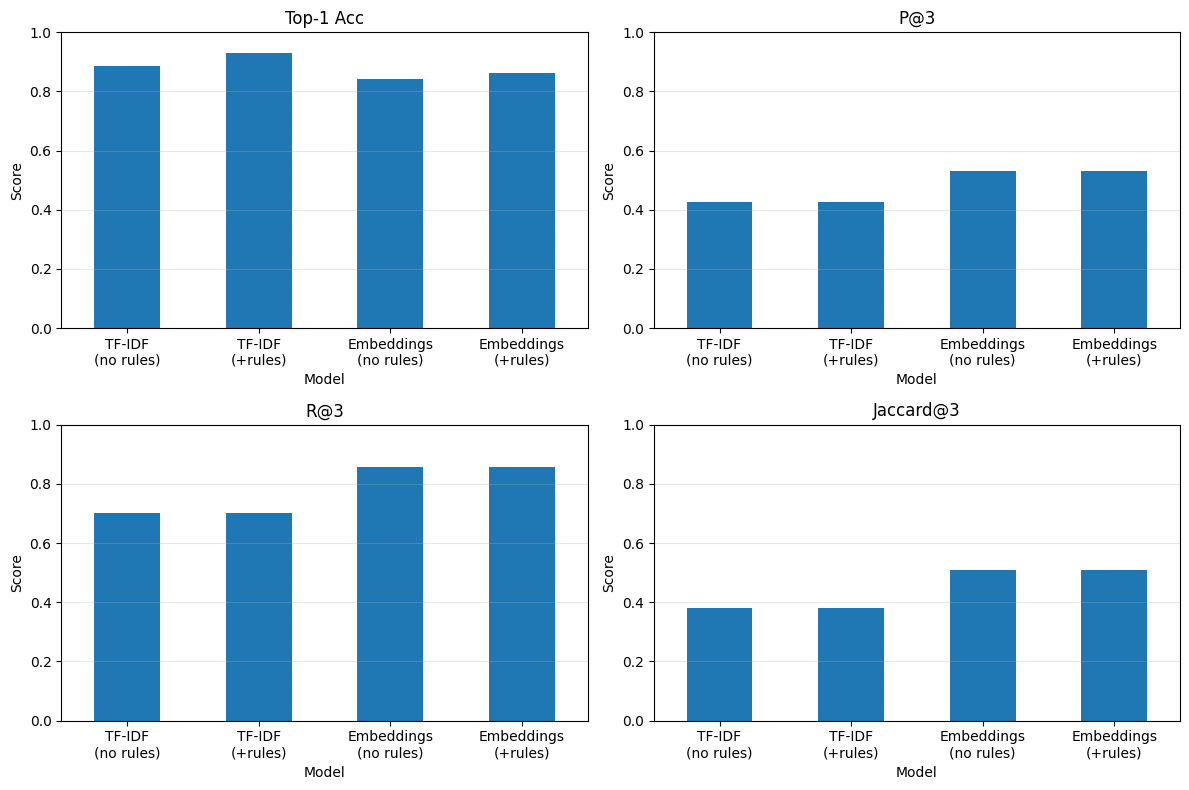

Saved plot to eval/tables/model_comparison.png


In [6]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

metrics = ['Top-1 Acc', f'P@{k}', f'R@{k}', f'Jaccard@{k}']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False)
    ax.set_title(metric)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.set_xticklabels(['TF-IDF\n(no rules)', 'TF-IDF\n(+rules)', 'Embeddings\n(no rules)', 'Embeddings\n(+rules)'], rotation=0)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../eval/tables/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved plot to eval/tables/model_comparison.png')

## 5. Example Predictions with Post-Rule Explanations

In [7]:
# Show a few examples with rule explanations
sample_size = 5
sample_preds = preds_tfidf_rules.head(sample_size)[['artifact_id', 'text', 'gold_controls', 'predicted_topk', 'postrule_notes']]

for _, row in sample_preds.iterrows():
    print(f"\n{'='*80}")
    print(f"Artifact {row['artifact_id']}:")
    print(f"Text: {row['text'][:100]}...")
    print(f"Gold: {row['gold_controls']}")
    print(f"Predicted: {row['predicted_topk']}")
    if row['postrule_notes']:
        print(f"Rules Applied: {row['postrule_notes']}")
    else:
        print("Rules Applied: None")


Artifact 3:
Text: Missing monthly patching; critical CVEs outstanding on db-02....
Gold: SI-2;RA-5
Predicted: SI-2;AC-17;SI-3
Rules Applied: None

Artifact 4:
Text: SIEM review missed for 30 days; high severity alerts untriaged....
Gold: AU-6;SI-4
Predicted: AU-6;SI-4;AC-2
Rules Applied: None

Artifact 13:
Text: NTP drift 120s on proxy-01; not synced to authoritative time source....
Gold: AU-8
Predicted: AU-8;AU-3;AC-17
Rules Applied: +0.10 AU-8 (any:ntp,time drift,time skew,clock drift,unsynced)

Artifact 15:
Text: File integrity monitoring not deployed on proxy-01 fleet; checksum alerts missing....
Gold: SI-7;SI-4
Predicted: SI-2;SI-7;SC-8
Rules Applied: None

Artifact 16:
Text: Backups not encrypted; last restore test older than 18 months....
Gold: CP-9;SC-28
Predicted: CP-9;AC-17;SI-3
Rules Applied: None
